### Import

In [1]:
from tqdm import tqdm; tqdm.pandas()
from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import NoneScaler, LogScaler, CustomLabelEncoder

device = torch.device("cuda")

### Config

In [2]:
test_mode = False

# Raw data
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 365
PRED_LEN = 100
is_non_zero = True

modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
}
processing_info = {
    "scaling_cols": {"sales": StandardScaler, "price": NoneScaler},
    "embedding_cols": ["day", "dow", "month", "holiday"],
}

# Model
batch_size = 32
nhead = 1
dropout = 0.1
is_identical = False

d_model = {"encoder":64, "decoder":32}
d_ff = {"encoder":64, "decoder":32}
num_layers = {"encoder":4, "decoder":2}
remain_rto = {"target": 0.25, "temporal":0.25, "cat":1}

# Data

### Raw data

In [3]:
if test_mode:
    df_preprocessed = pd.read_parquet("src/df_preprocessed_test.parquet")
else:
    if not is_prep_data_exist:
        rawdata = RawData()
        df_trans, df_meta, df_holiday = rawdata.get_raw_data()
        preprocess = Preprocess(df_trans, df_meta, df_holiday)
        df_preprocessed = preprocess.main()
    else:
        df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]

data_info = DataInfo(modality_info, processing_info)

In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto, is_non_zero)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

for data in train_dataloader:
    [print(key, val.shape) for key, val in data.items()]
    break

100%|██████████| 29388/29388 [00:01<00:00, 21079.72it/s]

sales torch.Size([32, 365, 1])
target_valid_idx torch.Size([32, 266])
sales_remain_idx torch.Size([32, 91])
sales_masked_idx torch.Size([32, 175])
sales_revert_idx torch.Size([32, 266])
target_remain_padding_mask torch.Size([32, 91])
target_masked_padding_mask torch.Size([32, 175])
target_revert_padding_mask torch.Size([32, 266])
day torch.Size([32, 365])
day_remain_idx torch.Size([32, 91])
day_masked_idx torch.Size([32, 175])
day_revert_idx torch.Size([32, 266])
dow torch.Size([32, 365])
dow_remain_idx torch.Size([32, 91])
dow_masked_idx torch.Size([32, 175])
dow_revert_idx torch.Size([32, 266])
month torch.Size([32, 365])
month_remain_idx torch.Size([32, 91])
month_masked_idx torch.Size([32, 175])
month_revert_idx torch.Size([32, 266])
holiday torch.Size([32, 365])
holiday_remain_idx torch.Size([32, 91])
holiday_masked_idx torch.Size([32, 175])
holiday_revert_idx torch.Size([32, 266])
price torch.Size([32, 365, 1])
price_remain_idx torch.Size([32, 91])
price_masked_idx torch.Size([32

# Train

### Model

In [6]:
def get_positional_encoding(d_model, seq_len=1000):
    position = torch.arange(seq_len).reshape(-1,1)
    i = torch.arange(d_model)//2
    exp_term = 2*i/d_model
    div_term = torch.pow(10000, exp_term).reshape(1, -1)
    pos_encoded = position / div_term

    pos_encoded[:, 0::2] = torch.sin(pos_encoded[:, 0::2])
    pos_encoded[:, 1::2] = torch.cos(pos_encoded[:, 1::2])

    return pos_encoded

class NoneEmbedding(torch.nn.Module):
    def forward(self, data):
        if len(data.shape) == 3:
            return data.to(torch.float)
        else:
            return data.unsqueeze(-1).to(torch.float)

class NumericalEmbedding(torch.nn.Module):
    def __init__(self, d_model, is_identical):
        super().__init__()
        self.linear_embedding = torch.nn.Linear(1, d_model)
        
        if is_identical: self.linear_embedding = NoneEmbedding()
    
    def forward(self, data):
        return self.linear_embedding(data)

class CategoricalEmbedding(torch.nn.Module):
    def __init__(self, num_cls, d_model, is_identical):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_cls, d_model)
        
        if is_identical: self.embedding = NoneEmbedding()
    
    def forward(self, data):
        return self.embedding(data)

class DynamicOutput(torch.nn.Module):
    def __init__(self, col, data_info, label_encoder_dict, d_model):
        super().__init__()
        if col in data_info.processing_info["scaling_cols"]:
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, 1)
                            )
        elif col in data_info.processing_info["embedding_cols"]:
            num_cls = label_encoder_dict[col].get_num_cls()
            self.output = torch.nn.Sequential(
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, d_model),
                            torch.nn.Linear(d_model, num_cls)
                            )
    
    def forward(self, data):
        
        return self.output(data)


1==1

True

In [7]:
class Transformer(torch.nn.Module):
    def __init__(self, data_info, label_encoder_dict,
                    d_model, num_layers, nhead, d_ff, dropout,
                    is_identical=False):
        super().__init__()
        self.data_info, self.label_encoder_dict, self.is_identical = data_info, label_encoder_dict, is_identical
        
        # Embedding
        self.numerical_embedding_dict = self._init_numerical_embedding_dict(d_model["encoder"])
        self.categorical_embedding_dict = self._init_categorical_embedding_dict(d_model["encoder"])

        # Positional encoding
        self.encoder_pos_enc = torch.nn.Parameter(get_positional_encoding(d_model["encoder"])) if not is_identical else torch.nn.Parameter(torch.zeros(1000, 1))
        self.decoder_pos_enc = torch.nn.Parameter(get_positional_encoding(d_model["decoder"])) if not is_identical else torch.nn.Parameter(torch.zeros(1000, 1))

        # Encoder modality embedding
        num_modality = len(self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"])
        self.encoder_modality_emb = torch.nn.Embedding(num_modality, d_model["encoder"]) if not is_identical else NoneEmbedding()
        self.decoder_modality_emb = torch.nn.Embedding(num_modality, d_model["decoder"]) if not is_identical else NoneEmbedding()

        # Encoding / Decoding
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model=d_model["encoder"], nhead=nhead, dim_feedforward=d_ff["encoder"], dropout=dropout, batch_first=True), num_layers["encoder"]) if not is_identical else NoneEmbedding()
        self.decoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model=d_model["decoder"], nhead=nhead, dim_feedforward=d_ff["decoder"], dropout=dropout, batch_first=True), num_layers["decoder"]) if not is_identical else NoneEmbedding()
        self.to_decoder_dim = torch.nn.Linear(d_model["encoder"], d_model["decoder"]) if not is_identical else NoneEmbedding()
        
        # Revert
        self.mask_token = torch.nn.Parameter(torch.rand(1, d_model["decoder"])) if not is_identical else torch.nn.Parameter(torch.zeros(1, 1) + 99)

        # Output
        self.output_dict = self._init_temporal_output(d_model["decoder"])
        
    
    def forward(self, input_data_dict, remain_rto, device):
        # Data to gpu
        data_dict, idx_dict, padding_mask_dict = self._to_gpu(input_data_dict, device)

        # Embedding
        embedding_dict = {}
        embedding_dict.update(self._apply_numerical_embedding(data_dict))
        embedding_dict.update(self._apply_categorical_embedding(data_dict))
        
        # Positional encoding
        temporal_dict = self._temporal_positional_encoding(embedding_dict, self.encoder_pos_enc)

        # Remain masking with valid idx
        remain_temporal_dict = self._apply_temporal_remain(temporal_dict, idx_dict)

        # Modality embedding
        remain_temporal_dict = self._apply_modality_encoding(remain_temporal_dict, self.encoder_modality_emb, device)

        # Encoding
        encoded = self.encoder((torch.cat(tuple(remain_temporal_dict.values()), dim=1)))
        encoded = self.to_decoder_dim(encoded)

        # Split
        encoded_temporal_dict = self._split(encoded, remain_temporal_dict)

        # Revert
        reverted_temporal_dict = self._apply_temporal_revert(encoded_temporal_dict, idx_dict, padding_mask_dict)
        reverted_totally_full_temporal_dict = self._apply_totally_full(reverted_temporal_dict, embedding_dict, idx_dict, padding_mask_dict, device)

        # Positional encoding
        reverted_totally_full_temporal_embedding = self._temporal_positional_encoding(reverted_totally_full_temporal_dict, self.decoder_pos_enc)
        reverted_temporal_embedding = self._apply_temporal_valid_idx(reverted_totally_full_temporal_embedding, idx_dict)

        # Modality embedding
        reverted_temporal_dict = self._apply_modality_encoding(reverted_temporal_embedding, self.decoder_modality_emb, device)

        # Decoding
        decoded = self.decoder((torch.cat(tuple(reverted_temporal_dict.values()), dim=1)))

        # Split
        decoded_temporal_dict = self._split(decoded, reverted_temporal_dict)

        # Output
        output = self._apply_temporal_output(decoded_temporal_dict)

        return output


    def _to_gpu(self, data, device):
        data_dict = {}
        idx_dict = {}
        padding_mask_dict = {}

        for col in data.keys():
            if col.endswith("padding_mask"):
                padding_mask_dict[col] = data[col].to(device)
            elif col.endswith("idx"):
                idx_dict[col] = data[col].to(device)
            elif col in self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]:
                data_dict[col] = data[col].to(device)
        
        return data_dict, idx_dict, padding_mask_dict
    
    def _init_numerical_embedding_dict(self, d_model):
        result_dict = {}
        target_cols = self.data_info.processing_info["scaling_cols"]
        for col in target_cols:
            result_dict[col] = NumericalEmbedding(d_model, self.is_identical)
        
        return torch.nn.ModuleDict(result_dict)

    def _apply_numerical_embedding(self, data):
        result_dict = {}
        target_cols = self.data_info.processing_info["scaling_cols"]
        for col in target_cols:
            result_dict[col] = self.numerical_embedding_dict[col](data[col])
        
        return result_dict

    def _init_categorical_embedding_dict(self, d_model):
        result_dict = {}
        target_cols = self.data_info.processing_info["embedding_cols"]
        for col in target_cols:
            num_cls = self.label_encoder_dict[col].get_num_cls()
            result_dict[col] = CategoricalEmbedding(num_cls, d_model, self.is_identical)
        
        return torch.nn.ModuleDict(result_dict)
    
    def _apply_categorical_embedding(self, data):
        result_dict = {}
        target_cols = self.data_info.processing_info["embedding_cols"]
        for col in target_cols:
            result_dict[col] = self.categorical_embedding_dict[col](data[col])
        
        return result_dict

    def _temporal_positional_encoding(self, data, pos_enc):
        pos_encoded_dict = {}

        for col, val in data.items():
            pos_encoded_dict[col] = val + pos_enc[:val.shape[1], :]

        return pos_encoded_dict

    def _apply_temporal_remain(self, data, idx_dict):
        result_dict = {}
        for col, val in data.items():
            remain_idx = idx_dict[f"{col}_remain_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            result_dict[col] = torch.gather(val, index=remain_idx, dim=1)
        
        return result_dict

    def _apply_modality_encoding(self, remain_dict, modality_emb, device):
        result_dict = {}
        modality_idx = 0
        for col, val in remain_dict.items():
            modality = torch.zeros(val.shape[1]).to(device) + modality_idx
            modality = modality_emb(modality.to(torch.int))
            result_dict[col] = val + modality
            modality_idx += 1
        
        return result_dict

    def _split(self, data, remain_temporal_dict):
        result_temporal_dict = {}
        start_idx = 0
        for col, val in remain_temporal_dict.items():
            length = val.shape[1]
            splitted = data[:, start_idx: start_idx+length, :]
            result_temporal_dict[col] = splitted

            start_idx += length
        
        return result_temporal_dict

    def _apply_temporal_revert(self, data, idx_dict, padding_mask_dict):
        result_dict = {}

        for col, val in data.items():
            # Replace remain_padding_mask to mask_token
            remain_padding_mask = padding_mask_dict["target_remain_padding_mask"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            mask_token = self.mask_token
            val = torch.where(remain_padding_mask==1, val, mask_token)

            # Revert
            revert_idx = idx_dict[f"{col}_revert_idx"].unsqueeze(-1).repeat(1, 1, val.shape[-1])
            mask_tokens = mask_token.unsqueeze(0).repeat(val.shape[0],
                                                        revert_idx.shape[1] - val.shape[1],
                                                        1)
            full_val = torch.cat([val, mask_tokens], dim=1)
            result_dict[col] = torch.gather(full_val, index=revert_idx, dim=1)
        
        return result_dict

    def _apply_totally_full(self, reverted_temporal_dict, original_embedding, idx_dict, padding_mask_dict, device):
        result_dict = {}
        valid_idx = idx_dict["target_valid_idx"]
        padding_mask = padding_mask_dict["target_revert_padding_mask"]
        for col, val in reverted_temporal_dict.items():
            first_values = val[:, 0, :].unsqueeze(1)
            replacement_mask = (padding_mask == 0)

            val = torch.where(replacement_mask.unsqueeze(-1), first_values.expand_as(val), val)

            totally_full_val = torch.zeros(original_embedding[col].shape[:-1]).to(device)
            totally_full_val = totally_full_val.unsqueeze(-1).repeat(1, 1, val.shape[-1])
            
            row_indices = torch.arange(totally_full_val.shape[0]).unsqueeze(-1)
            totally_full_val[row_indices, valid_idx, :] = val
            result_dict[col] = totally_full_val

        return result_dict

    def _apply_temporal_valid_idx(self, full_data, idx_dict):
        result_idx = {}
        valid_idx = idx_dict["target_valid_idx"]

        for n, (col, val) in enumerate(full_data.items()):
            if n == 0:
                valid_idx = valid_idx.unsqueeze(-1).repeat(1, 1, val.shape[-1])
            
            result_idx[col] = torch.gather(val, index=valid_idx, dim=1)
        
        return result_idx

    def _init_temporal_output(self, d_model):
        result_dict = {}
        # Others and temporal
        for col in self.data_info.modality_info["target"] + self.data_info.modality_info["temporal"]:
            result_dict[col] = DynamicOutput(col, self.data_info, self.label_encoder_dict, d_model) if not self.is_identical else NoneEmbedding()
        
        return torch.nn.ModuleDict(result_dict)
    
    def _apply_temporal_output(self, data):
        result_dict = {}
        for col, val in data.items():
            result_dict[col] = self.output_dict[col](val)
        
        return result_dict

1==1

True

In [8]:
model = Transformer(data_info, train_dataset.label_encoder_dict,
                        d_model, num_layers, nhead, d_ff, dropout,
                        is_identical)
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

--------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #
     Transformer             Embedding-1            [91, 64]             384             384
     Transformer    TransformerEncoder-2       [32, 546, 64]         100,864         100,864
     Transformer                Linear-3       [32, 546, 32]           2,080           2,080
     Transformer             Embedding-4           [266, 32]             192             192
     Transformer    TransformerEncoder-5      [32, 1596, 32]          12,928          12,928
Total params: 116,448
Trainable params: 116,448
Non-trainable params: 0
--------------------------------------------------------------------------------------------


'--------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)        Output Shape         Param #     Tr. Param #\n============================================================================================\n     Transformer             Embedding-1            [91, 64]             384             384\n     Transformer    TransformerEncoder-2       [32, 546, 64]         100,864         100,864\n     Transformer                Linear-3       [32, 546, 32]           2,080           2,080\n     Transformer             Embedding-4           [266, 32]             192             192\n     Transformer    TransformerEncoder-5      [32, 1596, 32]          12,928          12,928\n============================================================================================\nTotal params: 116,448\nTrainable params: 116,448\nNon-trainable params: 0\n------------------------------------------------------------------------------

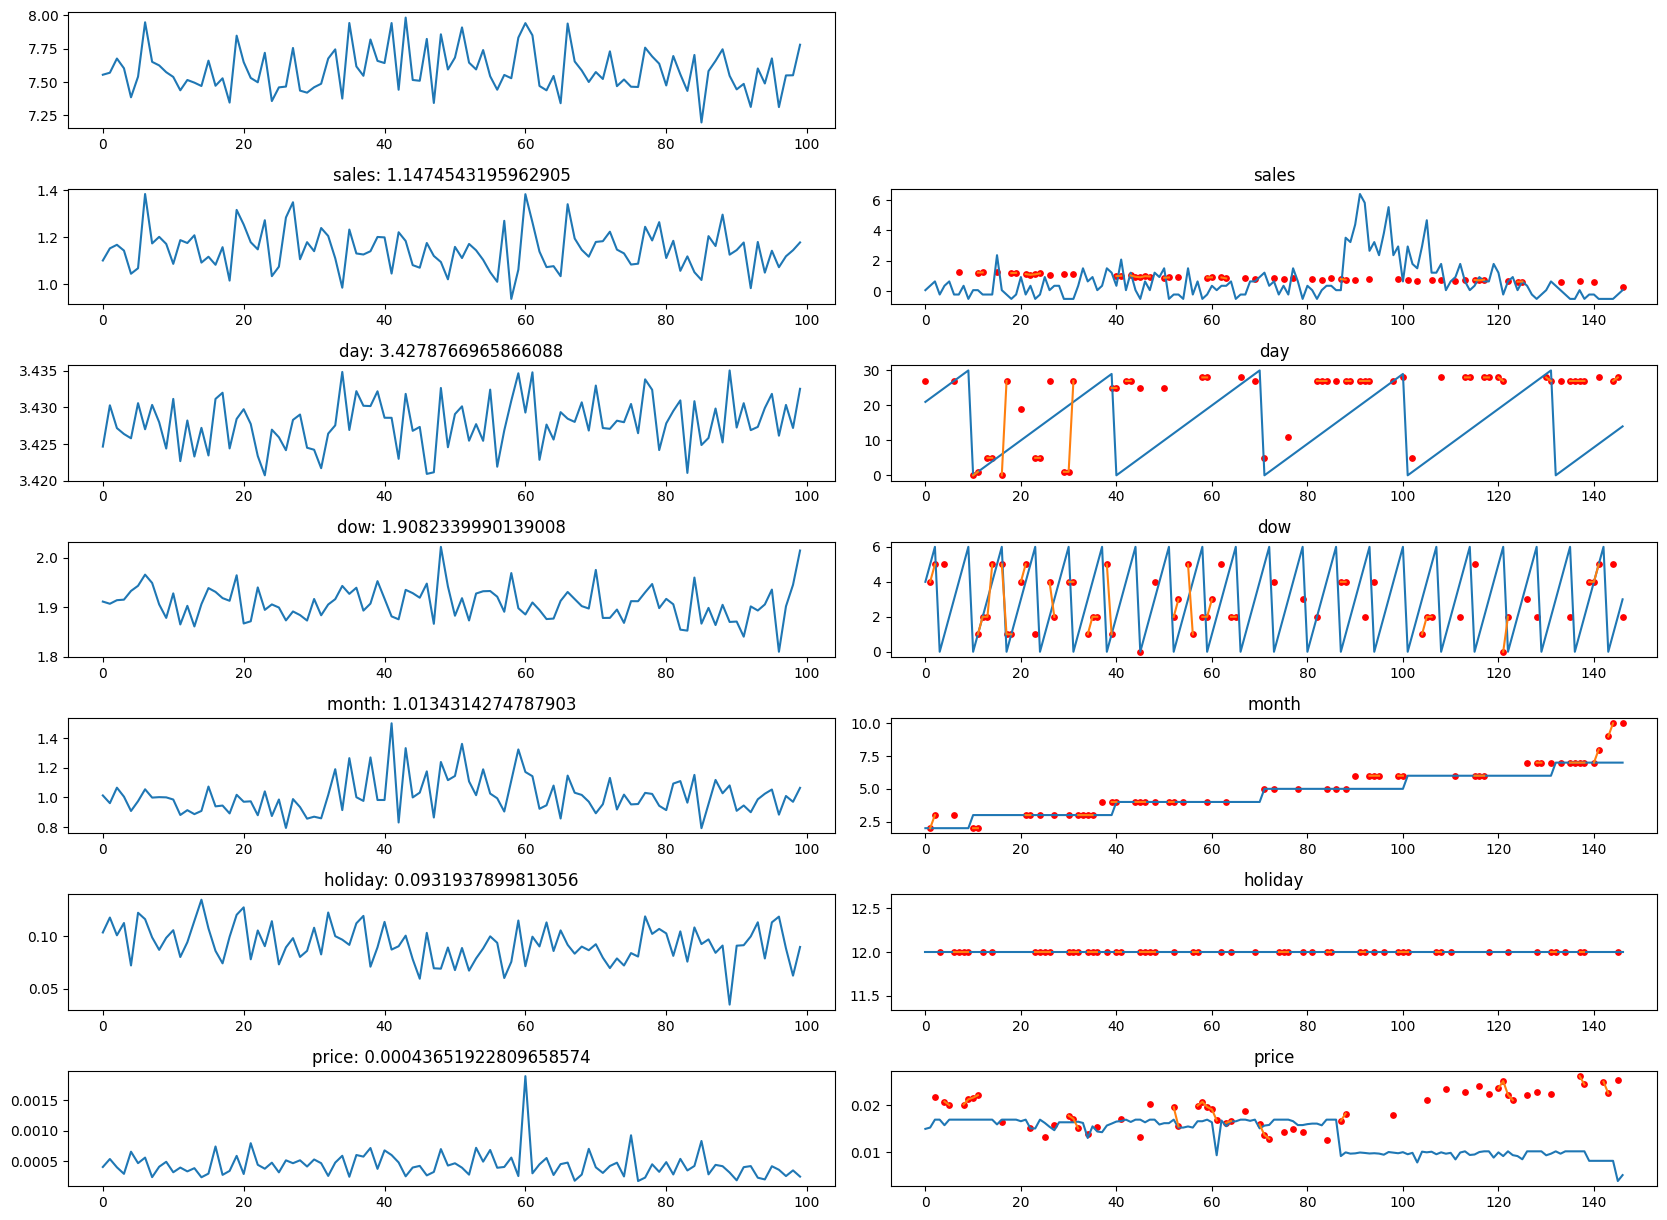

0 - loss: 7.585450201034546, lr: [0.001]:  63%|██████▎   | 579/919 [01:21<00:36,  9.39it/s] 

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
# mse_loss = torch.nn.L1Loss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")

def temporal_loss(col, pred, y, masked_idx, valid_idx, padding_mask=None):
    masked_idx = masked_idx.to(device)
    valid_idx = valid_idx.to(device)
    padding_mask = padding_mask.to(device)
    
    if col in data_info.processing_info["scaling_cols"]:
        pred = pred.squeeze()
        pred = torch.gather(pred, index=masked_idx, dim=1)
        
        y = y.squeeze().to(device)
        y = torch.gather(y, index=valid_idx, dim=1)
        y = torch.gather(y, index=masked_idx, dim=1)

        loss = mse_loss(pred, y)
        loss = torch.where(padding_mask == 1, loss, 0)
        loss = loss.sum() / padding_mask.sum()
    
    elif col in data_info.processing_info["embedding_cols"]:
        pred_masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        pred = torch.gather(pred, index=pred_masked_idx, dim=1)

        y = y.to(device).to(torch.long)
        y = torch.gather(y, index=valid_idx, dim=1)
        y = torch.gather(y, index=masked_idx, dim=1)

        loss = ce_loss(pred.reshape(-1, pred.shape[-1]), y.reshape(-1))
        loss = loss.view(y.shape)
        loss = torch.where(padding_mask == 1, loss, 0)
        loss = loss.sum() / padding_mask.sum()

    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    # pbar = tqdm(valid_dataloader)
    loss_li_dict, loss_li, window, grad_accm_step = defaultdict(list), [], 100, 0
    optimizer.zero_grad()

    for n, data in enumerate(pbar):
        optimizer.zero_grad()
        model.train()
        output = model(data, remain_rto, device)
        loss_dict = {}
        
        # Temporal loss
        for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            loss  = temporal_loss(col, output[col], data[col], data[f"{col}_masked_idx"], data["target_valid_idx"], data[f"target_masked_padding_mask"])
            loss_dict[col] = loss
            loss_li_dict[col].append(loss.item())
                
        # Sum loss
        loss = torch.nansum(torch.stack(list(loss_dict.values())))
        
        loss.backward()
        loss_li.append(loss.item())
        optimizer.step()
        
        msg = f"{e} - loss: {np.nanmean(loss_li[-window:])}, lr: {scheduler.get_last_lr()}"
        pbar.set_description(msg)
        
        if n % 20 == 0:
            model.eval()
            with torch.no_grad():
                output = model(data, remain_rto, device)
            idx = 0
            plt.figure(figsize=(25,35))
            nrows, ncols = 20, 3
            plot_idx = 1
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(loss_li[-window:])
            plot_idx += 2

            # Temporal samples
            for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
                # Loss
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(loss_li_dict[col][-window:])
                plt.title(f"{col}: {np.mean(loss_li_dict[col][-window:])}")

                # Sample
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)

                valid_len = data[f"target_revert_padding_mask"][idx].min(-1).indices
                valid_len = MAX_SEQ_LEN if valid_len==0 else valid_len

                y = data[col][idx][:valid_len].squeeze()
                pred = output[col][idx].detach().cpu()[:valid_len].squeeze()
                    
                if col in data_info.processing_info["embedding_cols"]:
                    pred = torch.argmax(pred, dim=-1)
                
                plt.plot(y, label="y")
                remain_valid_len = data[f"target_remain_padding_mask"][idx].min(-1).indices
                remain_valid_len = MAX_SEQ_LEN if remain_valid_len==0 else remain_valid_len

                masked_valid_len = data[f"target_masked_padding_mask"][idx].min(-1).indices
                masked_valid_len = MAX_SEQ_LEN if masked_valid_len==0 else masked_valid_len
                
                remain_index = data[f"{col}_remain_idx"][idx][:remain_valid_len]
                masked_index = data[f"{col}_masked_idx"][idx][:masked_valid_len]

                pred = pred.to(torch.float)
                y = y.to(torch.float)
                point = torch.tensor([torch.nan]).repeat(pred.shape)
    
                # pred[index] = y.to(torch.float)[index]
                pred[remain_index] = torch.nan
                point[masked_index] = pred.to(torch.float)[masked_index]
                plt.plot(pred, label="pred")
                plt.scatter(torch.arange(point.shape[0]), point, color="red", s=15)
                plt.title(col)

                # Attention weight
                plot_idx += 1
            
            
            
            plt.tight_layout()
            plt.show()

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()